In [1]:
import numpy as np

from qiskit import Aer, QuantumCircuit, QuantumRegister, assemble, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import GroverOperator

In [2]:
# Setting up a qiskit simulation is a bit involved. 
# The function below is simple setup that is sufficient for our goals here.
def quick_counts(qc):
    """Takes a quantum circuit and outputs the counts of the measurments (for a specific simulation)."""
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1024, memory=True)
    output = job.result()
    
    return output.get_counts()

In [3]:
def state_from_list(l):
    """ Converts a list `l` to a numpy array that can be used to initialize a state in qiskit.
    For example  [0, 0, 1, 0, 1] -> |00101> (in qiskit-friendly representation)."""
    
    l_str = "".join([str(i) for i in l])
    l_str = l_str[::-1] # qiskit convention
    
    return Statevector.from_label(l_str).data

# Overview

My goal in this notebook is to use Grover's algorithm to find a pre-image of some map $f$. More concretely, I will consider 1-1 maps between binary strings of length $n$, i.e. $f:\{0,1\}^n\to \{0,1\}^n$. I will call such functions ***hash*** functions. This is probably not the conventional definition but I think it is good enough example to illustrate the algorithm.

The notebook (and the logic of computation) is structured as follows. First I introduce some particular hash function $f_0$ on $n$ bits. Then I build a quantum circuit $U_0$ that implements this hash function. The quantum circuit requires $n$ additional ancilla qubits and acts as follows $U_0 |x\rangle_n|0\rangle_n=|x\rangle_n|f(x)\rangle_n$ for a state $|x\rangle$ in the computational basis.

Next, given a "hash" circuit $U_0$ and a marked element $|w\rangle$ I introduce an oracle $O_0(w)$. The oracle uses one more ancilla qubit and acts as follows $O_0(w)|x\rangle_n|0\rangle_n|0\rangle=|x\rangle_n|0\rangle_n|f_0(x)==w\rangle$, i.e. it flips the last ancilla qubit iff the marked element $w$ is the image of $x$.

Once one has the oracle, the Grover algorithm itself is quite straightforward to implement. This I do in the last part of the notebook.

---

*A note*: at first I intended to take any "hash" function $f$ as an input and produce the corresponding circuit $U_f$. Although this is possible in principle in practice I faced some problems. One is that the `qiskit` functionality that compiles a classical function to a quantum circuit https://qiskit.org/documentation/apidoc/classicalfunction.html does not work on my computer (nor in the cloud https://github.com/Qiskit/qiskit/issues/1253#issuecomment-839169725 ). So I had to be less ambitious and pick some function $f_0$ and construct a corresponding circuit $U_0$ by hands. However once $f_0$ and $U_0$ are defined, the rest of the computations in the notebook should generalize immediately.

# Define our working hash function $f_0$

With no good motivation let me define the following "hash" function $f_0$. It maps $f_0: (b_1) (b_2) \dots (b_{n-1}) (b_n) \mapsto  (b_1 \oplus b_n) (b_2 \oplus b_n) \dots (b_{n-1} \oplus b_n) (b_n)$. In words, it XOR's each bit with the last bit and leaves the last bit intact. For example $f_0: 0101\mapsto 0011$ and $f_0: 1100 \mapsto 1100$. That this function is 1-1 is guaranteed by the fact that $f_0(f_0(x))=x$.

In [4]:
def f0_hash(l):
    """A simple "hash" function."""
    
    l_image = []
    
    # XOR all bits with the last one
    for i in l[:-1]:
        xor = (i != l[-1])
        l_image.append(int(xor))
    
    # Leave the last one as is.
    l_image.append(l[-1])
    
    return l_image

Check

In [5]:
print ( f0_hash([0, 1, 0, 1]) == [1, 0, 1, 1] )
print ( f0_hash([1, 1, 0, 0]) == [1, 1, 0, 0] )

True
True


# Defining "hash" quantum circuit 

To do quantum computations we need a circuit that implements our hash function. I was hoping to use a standard library that automates this compilation procedure but could not make it work. So instead, let me build the circuit that implements $f_0$ by hands.

First define a useful helper function.

In [6]:
def xor(qc, q1, q2, qres):
    """Computes XOR or qubits q1 and q2 and "stores" the result in qubit qres."""
    
    qc.cx(q1, q2) # Now qubit q2 is in the state XOR(q1, q2)
    qc.cx(q2, qres) # Copy this value to the ancilla qubit
    qc.cx(q1, q2) # Uncompute and return q2 to its original state

Here is the circuit that does the same computation as our classical function $f_0$. To store the results of this computation we introduce $n$ more ancilla qubits. In effect, $U_0$ acts as $U_0 |x\rangle_n|0\rangle_n=|x\rangle_n|f_0(x)\rangle_n$.

In [7]:
def U0_hash(n_bits):
    """Quantum circuit corresponding to f0. First `n_bits` specify the arguments of the hash function.
    The value of the hash function is stored in `n_bits` ancilla qubits."""
    
    n_qubits = 2*n_bits # We need as much ancilla qubits as classical bits
    
    qc = QuantumCircuit(n_qubits) 
    
    # Loop over all but the last qubits, compute XORs with the last qubit and copy result to the ancilla qubits.
    for n in range(n_bits-1):
        xor(qc, n, n_bits-1, n+n_bits)
    
    qc.cx(n_bits-1, n_qubits-1) # last bit is simply copied to the last ancilla qubit
    
    return qc

Example

Let us check that this circuit does what it should.

In [8]:
n_bits = 4
n_qubits = 2*n_bits
l = [1, 0, 0, 1]

qc = QuantumCircuit(n_qubits, n_bits)
qc.initialize(state_from_list(l), range(n_bits))
qc += U0_hash(n_bits)
qc.measure(range(n_bits, n_qubits), range(n_bits))
qc.draw()

┌──────────────────────────────────────────────┐                         »
q_0: ┤0                                             ├──■─────────■────────────»
     │                                              │  │         │            »
q_1: ┤1                                             ├──┼─────────┼────■───────»
     │  initialize(0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0) │  │         │    │       »
q_2: ┤2                                             ├──┼─────────┼────┼───────»
     │                                              │┌─┴─┐     ┌─┴─┐┌─┴─┐     »
q_3: ┤3                                             ├┤ X ├──■──┤ X ├┤ X ├──■──»
     └──────────────────────────────────────────────┘└───┘┌─┴─┐└┬─┬┘└───┘  │  »
q_4: ─────────────────────────────────────────────────────┤ X ├─┤M├────────┼──»
                                                          └───┘ └╥┘      ┌─┴─┐»
q_5: ────────────────────────────────────────────────────────────╫───────┤ X ├»
                                                                 ║       └───┘»
q_6: ────────────────────────────────────────────────────────────╫────────────»
                                                                 ║            »
q_7: ────────────────────────────────────────────────────────────╫────────────»
                                                                 ║            »
c: 4/════════════════════════════════════════════════════════════╩════════════»
                                                                 0            »
«                                 
«q_0: ────────────────────────────
«                                 
«q_1: ──■─────────────────────────
«       │                         
«q_2: ──┼────■─────────■──────────
«     ┌─┴─┐┌─┴─┐     ┌─┴─┐        
«q_3: ┤ X ├┤ X ├──■──┤ X ├──■─────
«     └───┘└───┘  │  └───┘  │     
«q_4: ────────────┼─────────┼─────
«      ┌─┐        │         │     
«q_5: ─┤M├────────┼─────────┼─────
«      └╥┘      ┌─┴─┐ ┌─┐   │     
«q_6: ──╫───────┤ X ├─┤M├───┼─────
«       ║       └───┘ └╥┘ ┌─┴─┐┌─┐
«q_7: ──╫──────────────╫──┤ X ├┤M├
«       ║              ║  └───┘└╥┘
«c: 4/══╩══════════════╩════════╩═
«       1              2        3

We can run the cicuit and check that the output matches the value of the classical hash function $f_0$ (in reversed order)

[0, 1, 1, 1]


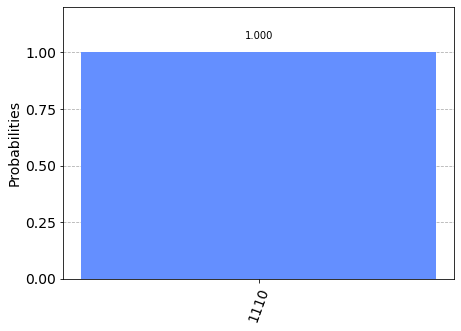

In [9]:
print(f0_hash(l))
plot_histogram(quick_counts(qc))

# Oracle for the hash function

In Grover's algorithm one uses an oracle -- a circuit that distinguishes a specified element. Let us construct such an oracle from a pair $U$, $|w\rangle$ where $U$ is $2n$ dimensional circuit implementing the hash function and $|w\rangle$ is a marked vector. The oracle will use one extra ancilla quibit to store the result of the check whether initial state $|s\rangle$ is the preimage of $|w\rangle$. So the oracle $O_0(w)$ acts as $O_0(w) |x\rangle_n|0\rangle_n|0>=|x\rangle_n|0\rangle_n|f_0(x)==w\rangle$.

In [10]:
def hash_oracle(U, w):
    """Circuit that checks if `w` is the image of the initial state under the hash function corresponding to U.
    If it is, the value of the last ancilla qubit is filpped. If not, the original state is returned."""
    
    n_bits = len(w)
    n_qubits = len(U.qubits)
    
    assert n_qubits == 2*n_bits, "Target state must have half dimension of the hash circuit."
    
    # Helper function
    def add_w_complement(qc):
        """Add bitwise values of "not `w`" to the states in the corresponding registers.
        Conjugating the Toffoli gate with this operator effectively gives a toffoli gate
        conditional on the control state being `w`. Pehaps there is a standard implementation of this."""
        regs = range(n_bits, n_qubits)
        for i, r in zip(w, regs):
            if not i:
                qc.x(r)
    
    # Initializae the circuit
    qc = QuantumCircuit(n_qubits+1) # One additional ancilla qubit to store the value of the check `initial state`==`w`.
    qc.barrier()
    
    # Apply hash circuit
    qc = qc.compose(U, range(n_qubits))
    qc.barrier()
    
    # This block applies the toffoli gate only if the input state of the ancilla qubits is `w`
    add_w_complement(qc)
    qc.mct(list(range(n_bits, n_qubits)), n_qubits)
    add_w_complement(qc) # Uncompute addition of `w`
    qc.barrier()
    
    # Uncompute hash circuit
    qc = qc.compose(U, range(n_qubits))

    return qc

Let us check that the oracle does what is expected.

In [11]:
n_bits = 3
n_qubits = 2*n_bits
w = [1, 0, 1] # Just an example of a marked state

# Hash value of `w` is
f0_hash(w)

[0, 1, 1]

First let us take the initial state for the circuit to be different from hash value of `w`

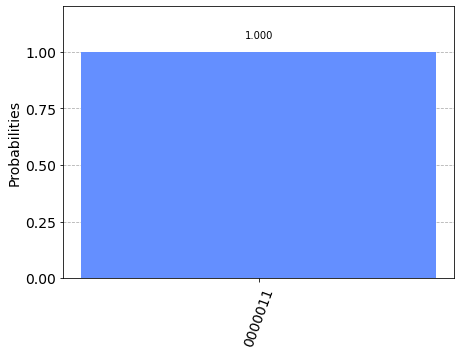

In [12]:
s=[1, 1, 0]

qc = QuantumCircuit(n_qubits+1)
qc.initialize(state_from_list(s), range(n_bits))
qc += hash_oracle(U0_hash(n_bits), w) 
qc.measure_all()
plot_histogram(quick_counts(qc))

The (reversed) answer is '110 000 0'. The first three most significat bits are just our initial state `s`. The following three bits correspond to ancilla qubits and are consistenly all 0 since the computation is clean. The most important piece is the last bit which shows if the initial state `s` is preimage of the target state `w`. In this case it is not.

Now let us take `s` that is a preimage of `w` and repeat the computation.

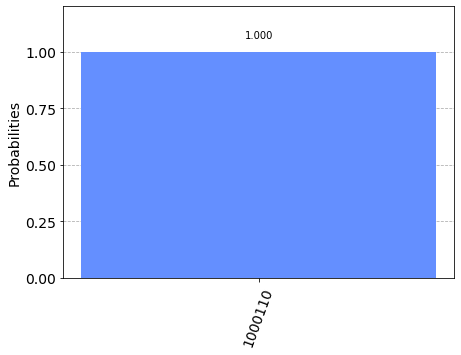

In [13]:
s = f0_hash(w)

qc = QuantumCircuit(n_qubits+1)
qc.initialize(state_from_list(s), range(n_bits))
qc += hash_oracle(U0_hash(n_bits), w) 
qc.measure_all()
plot_histogram(quick_counts(qc))

Here we see that the initial state of the qubits is inaffected but the last bit being 1 signifies that our initial `s` is indeed a preimage of `w`.

One last thing we need to do before we can implement the Grover algorithm is to slightly modify our oracle. Now it is a bit-flip oracle. Meaning that it flips the last ancilla qubit.  We will convert it to the phase to the phase-flip oracle which instead flips the overall sign of the state. 

In [14]:
def phase_hash_oracle(bit_oracle):
    """Makes bit-flip hash oracle into a phase-flip hash oracle."""
    
    n_qubits = len(bit_oracle.qubits)
    
    qc = QuantumCircuit(n_qubits)
    qc.x(n_qubits-1)
    qc.h(n_qubits-1)
    qc = qc.compose(bit_oracle)
    qc.h(n_qubits-1)
    qc.x(n_qubits-1)
    
    return qc

# Finally, Grover's algorithm itself

Let us start from a particular setup. We will choose dimension of our problem =`n_bits` and a marked state `w`. These variables can be changed to test the algorithm in different cases.

In [15]:
n_bits = 6
n_qubits = 2*n_bits
w = [1, 1, 0, 1, 0, 1] # marked state

assert len(w)==n_bits, "Marked element has wrong dimension."

Now for the actual heavy lifting. Grover's algorithm consists of three main parts. 
1. Initialialize initial state to the equal superposition of all computational basis states $|s\rangle>=\frac{1}{\sqrt{2^n}}\sum_x |x\rangle_n$.
2. Make one grover iteration which consists of a phase oracle followed by a diffusor (reflection about $|s\rangle$). Repeat total number of times $n_{steps}\approx \frac{\pi \sqrt{2^n}}{4}$.
3. Measure in the computational basis. With very hight probability the measured vector is the sought-for preimage of the marked stated.

Let us implement this.

In [16]:
# Number of Grover iterations
n_steps = int(np.floor(np.pi*np.sqrt(2**n_bits)/4)) 

# Build oracle from a given marked state
bit_oracle = hash_oracle(U0_hash(n_bits), w)
phase_oracle = phase_hash_oracle(bit_oracle)

# Define quantum circuit and initialize it into equal superposition state |s> .
# Note: all ancilla qubits must remain in state |0>
qc = QuantumCircuit(n_qubits+1, n_bits)
s = Statevector.from_label('+'*n_bits).data # equal superposition state
qc.initialize(s, range(n_bits)) 

# Single grover iteration. Function GroverOperator conveniently adds a diffusor (which is universal) to our oracle.
grover_step = GroverOperator(phase_oracle, reflection_qubits=list(range(n_bits)), insert_barriers=True)

# Do required number of iterations.
for _ in range(n_steps):
    qc = qc.compose(grover_step)

Now we are ready to run the circuit and see the results.

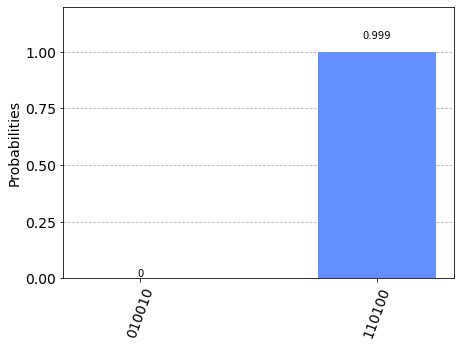

In [17]:
qc.measure(range(n_bits), range(n_bits)) # Only first n qubits specify the state that we look for.
plot_histogram(quick_counts(qc))

Finally, compare with the pre-image of our marked element `w` (again, the order is reversed)

In [18]:
print(f0_hash(w))

[0, 0, 1, 0, 1, 1]


So, it works! To check different cases one can alter the dimension of the problem `n_bits` and the marked element `w` specified at the beginning of this section and then re-run the computations.